# Predict your taxi fare in NYC
This <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset 
with about 55 million records. The data contains only the pickup date & time, the latitude & longitude 
(GPS coordinates) of the pickup and dropoff locations, and the number of passengers. 
It is up to the contest participant to extract any further information. For instance, does the time of day matter? 
The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

I've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll go through some feature engineering before train and test.

# All the necessary imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Update the path to reflect your settings

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

We see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

# Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

Here is the formula

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat_1, long_1, lat_2, long_2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    earth_r = 6371  # average radius of Earth in kilometers
       
    phi_1 = np.radians(df[lat_1])
    phi_2 = np.radians(df[lat_2])
    
    delta_phi = np.radians(df[lat_2]-df[lat_1])
    delta_lambda = np.radians(df[long_2]-df[long_1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    k_distance = (earth_r * c) # in kilometers
    m_distance = k_distance * 0.621371 # in miles

    return m_distance

In [5]:
df['dist_miles'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.321228
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,0.865139
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2.067154
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.158316
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4.493333


# Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,1.321228,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,0.865139,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2.067154,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.158316,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,4.493333,2010-04-16 22:19:01,22,pm,Fri


# Separate categorical from continuous columns

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_miles', 'EDTdate', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')

In [8]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
# we entered the continuous columns explicitly because there are columns we're not running through the model (pickup_datetime and EDTdate)
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_miles']

# If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:
# cont_cols = [col for col in df.columns if col not in cat_cols + y_col]

y_col = ['fare_amount']  # this column contains the labels


# Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [9]:
# Convert our three categorical columns ['Hour', 'AMorPM', 'Weekday'] to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [10]:
# lets print and check all the data types in data frame
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_miles                  float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that df['Hour'] is a categorical feature by displaying some of the rows:

In [11]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

In [12]:
# lets check some df['AMorPM'] values
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [13]:
# lets check some df['Weekday'] values
df['Weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This makes more sense when we look at <tt>df['AMorPM']</tt>:

In [14]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [15]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [16]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [17]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using numpy.stack We don't want the Series index, just the values.

In [18]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

# all of the above can also be done in one line (more pythonic way)
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)

cats.shape

(120000, 3)

In [19]:
# prints only 5 rows
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

# Convert numpy arrays to tensors

In [20]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

In [21]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   1.3212],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   0.8651],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   2.0672],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.1583],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   4.4933]])

In [22]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [23]:
cats.shape

torch.Size([120000, 3])

In [24]:
conts.shape

torch.Size([120000, 6])

In [25]:
y.shape

torch.Size([120000, 1])

# Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [26]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

In [27]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [28]:
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [29]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

# Define loss function & optimizer

In [30]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # start with a lower learning rate. adjust as needed

# Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [31]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [32]:
len(cat_train)

48000

In [33]:
len(cat_test)

12000

In [34]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # print loss every 25 epoch:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.61173439
epoch:  26  loss: 10.85527706
epoch:  51  loss: 10.25410557
epoch:  76  loss: 9.83049202
epoch: 101  loss: 9.32765770
epoch: 126  loss: 8.58510876
epoch: 151  loss: 7.56745005
epoch: 176  loss: 6.37473774
epoch: 201  loss: 5.13032484
epoch: 226  loss: 4.18729448
epoch: 251  loss: 3.85507035
epoch: 276  loss: 3.72677016
epoch: 300  loss: 3.65732861

Duration: 472 seconds


# Plot the loss function

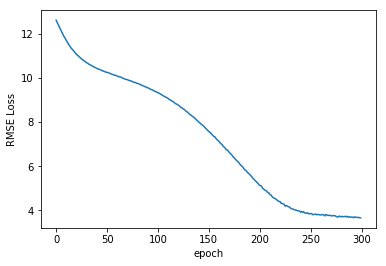

In [35]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [36]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.63473201


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [37]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.6191   2.9000   1.7191
 2.  19.7270   5.7000  14.0270
 3.   5.8425   7.7000   1.8575
 4.  12.2872  12.5000   0.2128
 5.   6.5582   4.1000   2.4582
 6.   5.0732   5.3000   0.2268
 7.   3.4407   3.7000   0.2593
 8.  17.0238  14.5000   2.5238
 9.   3.1665   5.7000   2.5335
10.   9.8814  10.1000   0.2186
11.   6.1182   4.5000   1.6182
12.   4.3944   6.1000   1.7056
13.   8.5327   6.9000   1.6327
14.  12.7728  14.1000   1.3272
15.   3.3644   4.5000   1.1356
16.  26.7391  34.1000   7.3609
17.   4.2068  12.5000   8.2932
18.   8.3284   4.1000   4.2284
19.   8.5145   8.5000   0.0145
20.   5.1743   5.3000   0.1257
21.  17.9631  11.3000   6.6631
22.   8.0179  10.5000   2.4821
23.  16.8904  15.3000   1.5904
24.  14.9869  14.9000   0.0869
25.  42.3847  49.5700   7.1853
26.   4.8758   5.3000   0.4242
27.   7.3881   3.7000   3.6881
28.   7.3156   6.5000   0.8156
29.  14.2969  14.1000   0.1969
30.   6.0504   4.9000   1.1504
31.   4.5704   3.7000   0.8704
32.  48.

So while many predictions were off by a few cents, some were off by \\$10.00 or \\$14.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

# Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [38]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'NYC-Taxi-Fare-Model.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [39]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat_1, long_1, lat_2, long_2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    earth_r = 6371  # average radius of Earth in kilometers
       
    phi_1 = np.radians(df[lat_1])
    phi_2 = np.radians(df[lat_2])
    
    delta_phi = np.radians(df[lat_2]-df[lat_1])
    delta_lambda = np.radians(df[long_2]-df[long_1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    k_distance = (earth_r * c) # in kilometers
    m_distance = k_distance * 0.621371 # in miles

    return m_distance

class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value).

In [40]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [41]:
model2.load_state_dict(torch.load('NYC-Taxi-Fare-Model.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [42]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [43]:
z = test_data(model2)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.8
What is the dropoff latitude?  40.53
What is the dropoff longitude? -73.92
How many passengers? 1
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2019-12-16 18:00:00

The predicted fare amount is $25.91
